In [ ]:
!pip install webcolors -qq

In [3]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image, center_crop
from torchvision.utils import draw_segmentation_masks, make_grid
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from google.colab import drive
import os

import cv2
import pandas as pd
import numpy as np
import os
import random

from PIL import Image

from webcolors import rgb_to_name

from tqdm import tqdm

from matplotlib.image import imread

%matplotlib inline

In [15]:
base_dir = "/content/drive/MyDrive/APS360 Project/archive/aug_dataset/"

DATA_DIR = os.path.join(base_dir, "train")
COLOR_CODES = pd.read_csv(os.path.join(base_dir, "class_dict.csv"))
annotations = pd.read_csv(os.path.join(base_dir, "metadata.csv"))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/APS360 Project/archive/aug_dataset/class_dict.csv'

In [ ]:
first_dir = os.listdir(DATA_DIR)[0]
file_path = "/content/drive/MyDrive/APS360 Project/archive/aug_dataset/train/0_sat.jpg"

with Image.open(file_path) as img:
    # Get the size of the image
    width, height = img.size
    # Print the size of the image
    print(f"size: {width}x{height}")

size: 2448x2448


In [ ]:
# Initialize counters
num_files = 0
num_folders = 0

# Iterate through the items in the folder
for item in os.listdir(DATA_DIR):
    item_path = os.path.join(DATA_DIR, item)
    if os.path.isfile(item_path):
        num_files += 1

print(f"Number of files: {num_files/2}")

Number of files: 1404.0


In [ ]:
column_name = "split"
img_name = "sat_image_path"
mask_name = "mask_path"

# Extract the specific column
column_data = annotations[column_name]

train_list = []
train_mask = []
valid_list = []
valid_mask = []
test_list = []
test_mask = []
for i in range(len(column_data)):
  if column_data[i] == "train":
    train_list.append(annotations[img_name][i])
    train_mask.append(annotations[mask_name][i])
  elif column_data[i] == "valid":
    valid_list.append(annotations[img_name][i])
    valid_mask.append(annotations[mask_name][i])
  else:
    test_list.append(annotations[img_name][i])
    test_mask.append(annotations[mask_name][i])

In [ ]:
print(len(train_list))
print(len(valid_list))
print(len(test_list))

601
101
101


In [14]:
# map classes to RGB values
label_map = {}
for index, row in COLOR_CODES.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

NameError: name 'COLOR_CODES' is not defined

In [ ]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, image_list, label_list, label_map, transform):
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = image_list
        self.targets_name = label_list

    def __len__(self):
        return len(self.images_name)

    def __dataaug__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        # mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = Image.fromarray(image)
            mask = Image.fromarray(mask)

            if random.random() > 0.5 and random.random() < 0.75:
                image_transformed = TF.hflip(image)
                mask_transformed = TF.hflip(mask)

                if random.random() > 0.5:
                  colour_jitter = transforms.ColorJitter(brightness=0.5, contrast=0.1)
                  image_transformed = colour_jitter(image_transformed)
                  mask_transformed = colour_jitter(mask_transformed)

                  self.save_transformed_data(image_transformed, mask_transformed, idx)
                  train_list.append(f"{idx}_sat.jpg")
                  train_mask.append(f"{idx}_mask.jpg")

            elif random.random() > 0.75 and random.random() < 1:
                image_transformed = TF.vflip(image)
                mask_transformed = TF.vflip(mask)

                if random.random() > 0.5:
                  colour_jitter = transforms.ColorJitter(brightness=0.7, contrast=0.1)
                  image_transformed = colour_jitter(image_transformed)
                  mask_transformed = colour_jitter(mask_transformed)

                  self.save_transformed_data(image_transformed, mask_transformed, idx)
                  train_list.append(f"{idx}_sat.jpg")
                  train_mask.append(f"{idx}_mask.jpg")

            else:
                colour_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2)
                image_transformed = colour_jitter(image)
                mask_transformed = colour_jitter(mask)

                self.save_transformed_data(image_transformed, mask_transformed, idx)
                train_list.append(f"{idx}_sat.jpg")
                train_mask.append(f"{idx}_mask.jpg")

    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

    def save_transformed_data(self, image, mask, idx):
        save_dir = "/content/drive/MyDrive/APS360 Project/archive/train"
        os.makedirs(save_dir, exist_ok=True)

        image_path = os.path.join(save_dir, f"{idx}_sat.jpg")
        mask_path = os.path.join(save_dir, f"{idx}_mask.png")

        image.save(image_path)
        mask.save(mask_path)

In [ ]:
# DATA ALREADY GENERATED; DO NOT RUN THIS
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])
num_classes = len(label_map.keys())

train_dataset = Segmentation_Dataset(base_dir, train_list, train_mask, label_map, transform)

# Optionally, loop over the dataset to apply data augmentation
for i in range(len(train_dataset)):
    train_dataset.__dataaug__(i)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
import csv

# Define the path to your CSV file
csv_file_path = '/content/drive/MyDrive/APS360 Project/archive/no_aug_dataset/metadata.csv'

# Open the CSV file in 'append' mode
with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)

    for i in range(601):
    # Write an empty row
      writer.writerow([])

In [ ]:
dir = pd.read_csv("/content/drive/MyDrive/APS360 Project/archive/aug_dataset/Copy of metadata2_GOOD - metadata2.csv")

# Write new data to file
column_name = "split"
img_name = "sat_image_path"
mask_name = "mask_path"

# Extract the specific column
column_data = dir[column_name]

train_list = []
train_mask = []
valid_list = []
valid_mask = []
test_list = []
test_mask = []


for i in range(601):
    with open('/content/drive/MyDrive/APS360 Project/archive/aug_dataset/Copy of metadata2_GOOD - metadata2.csv', mode='a', newline='') as file:
        writer = csv.writer(file)
        new_row = [
            i,  # image_id
            "train",  # split
            f"train/{i}_sat.jpg",  # sat_image_path
            f"train/{i}_mask.png"   # mask_path
        ]
        writer.writerow(new_row)

for i in range(601):




In [ ]:
xlabel = {'urban_land': [0,255,255],
         'agriculture_land': [255,255,0],
         'rangeland': [255,0,255],
         'forest_land': [0,255,0],
         'water': [0,0,255],
         'barren_land': [255,255,255],
         'unknown': [0,0,0]}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


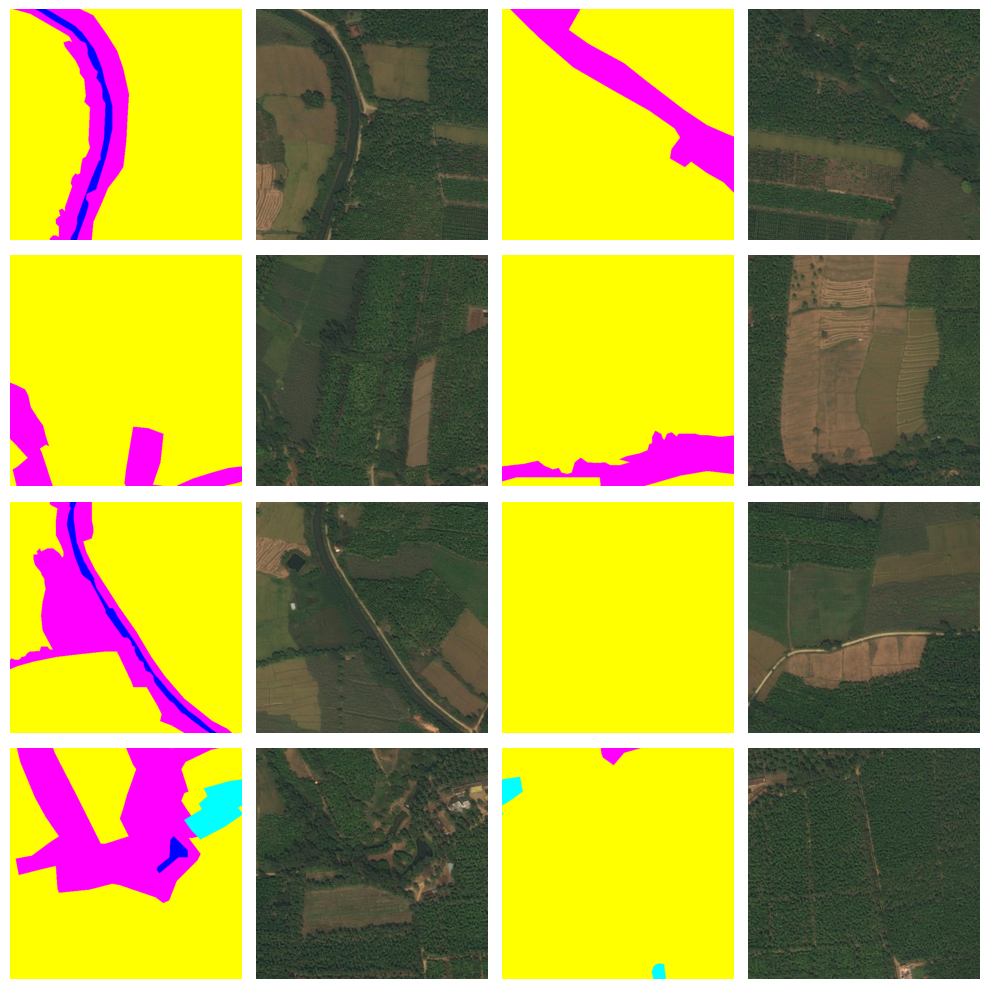

In [13]:
import matplotlib.pyplot as plt
nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows, 4, figsize=(10, 10))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])
k = 0
path = "/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/"
for i in range(4):
    for j in range(0, 4, 2):
      img = os.path.join(path, "119_sat_{0}.jpg".format(k))
      mask = os.path.join(path, "119_mask_{0}.png".format(k))
      img = cv2.imread(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      k += 1

      axes[i, j].imshow(mask)
      axes[i, j].axis('off')
      axes[i, j+1].imshow(img)
      axes[i, j+1].axis('off')
plt.tight_layout()
# plt.show()

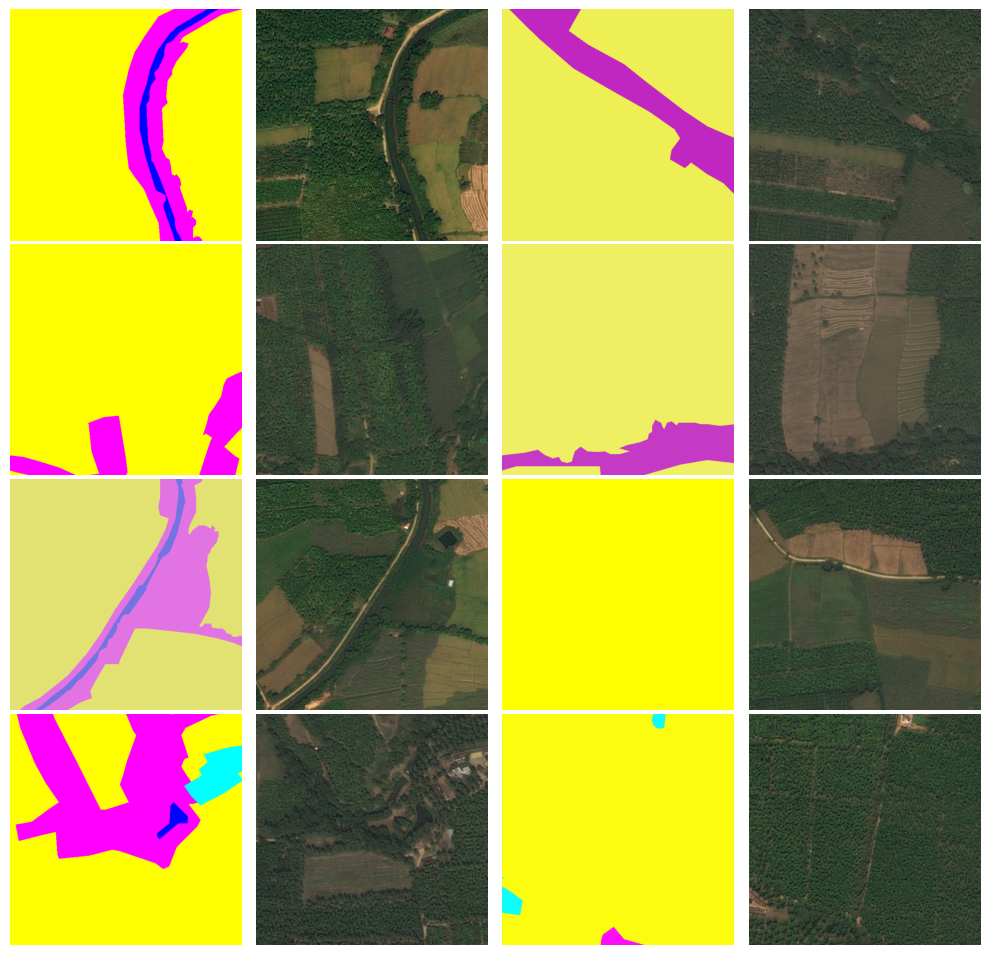

In [31]:
k = 0
fig, axes = plt.subplots(nrows, 4, figsize=(10, 10))

for i in range(4):
    for j in range(0, 4, 2):
      img = os.path.join(path, "119_sat_{0}.jpg".format(k))
      mask = os.path.join(path, "119_mask_{0}.png".format(k))
      img = cv2.imread(img)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(mask)
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      k += 1

      image = Image.fromarray(img)
      mask = Image.fromarray(mask)

      if random.random() > 0.5 and random.random() < 0.75:
        image_transformed = TF.hflip(image)
        mask_transformed = TF.hflip(mask)

        if random.random() > 0.5:
          colour_jitter = transforms.ColorJitter(brightness=0.05, contrast=0.6)
          image_transformed = colour_jitter(image_transformed)
          mask_transformed = colour_jitter(mask_transformed)
      elif random.random() > 0.75 and random.random() < 1:
          image_transformed = TF.vflip(image)
          mask_transformed = TF.vflip(mask)

          if random.random() > 0.5:
            colour_jitter = transforms.ColorJitter(brightness=0.01, contrast=0.1)
            image_transformed = colour_jitter(image_transformed)
            mask_transformed = colour_jitter(mask_transformed)

      else:
          colour_jitter = transforms.ColorJitter(brightness=0.02, contrast=0.2, saturation = 0.5)
          image_transformed = colour_jitter(image)
          mask_transformed = colour_jitter(mask)

      img_transformed = np.array(image_transformed)
      mask_transformed = np.array(mask_transformed)

      axes[i, j].imshow(mask_transformed)
      axes[i, j].axis('off')
      axes[i, j+1].imshow(image_transformed)
      axes[i, j+1].axis('off')
      plt.tight_layout()

